In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [3]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [4]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month=list(sorted(set(mrat_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(mrat_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    mrat_weights=mrat_wo_na.loc[closest_dates].copy().fillna(0)
    
    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return mrat_weights,sorted(dates_end)

In [5]:
def get_portfolios(mrat_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_rebased=top/top.sum()
            top_dict=top_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_dict: 
                    weight_dict[key]=top_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


In [6]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).cumsum(axis=1).T
    
    return pnl_dataframe.iloc[:-2]

# Dataset

In [8]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
#url='https://en.wikipedia.org/wiki/CAC_40'
table = pd.read_html(url)
df = table[0]

In [9]:
#tickers=df['Symbol'].tolist()
tickers=df['Symbol'].tolist()


In [10]:
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime(2019,6,15)).strftime("%Y-%m-%d")
#analysis_start_date = (datetime.datetime.now() - datetime.timedelta(days=365*4)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2019-06-15 -> 2025-02-13)


In [11]:
sp500=get_close(['SPY'],start=start_date,end=end_date)
sp500_leverage=get_close(['XS2D.L'],start=start_date,end=end_date)

# Analysis

In [13]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}
mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

In [14]:
mrat_weights = mrat_weights[~mrat_weights.index.duplicated(keep='first')]

In [15]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=10,weight_dict=weight_dict,
                                  mrat_weights=mrat_weights,dates_end=dates_end,
                                  transaction_fee=0.005)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12464\3430555856.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2019-06-17 00:00:00 100 1.0
2020-03-31 00:00:00 83.95657978664981 0.8395657978664981
2020-04-30 00:00:00 103.51505151408105 1.0351505151408105
2020-05-29 00:00:00 114.24512607374763 1.1424512607374764
2020-06-30 00:00:00 121.2186076572684 1.212186076572684
2020-07-31 00:00:00 143.89409227375342 1.438940922737534
2020-08-31 00:00:00 165.77556830011952 1.6577556830011952
2020-09-30 00:00:00 164.85102575021966 1.6485102575021966
2020-10-30 00:00:00 164.53075129346743 1.6453075129346744
2020-11-30 00:00:00 190.85655633231545 1.9085655633231544
2020-12-31 00:00:00 204.07140637760267 2.0407140637760266
2021-01-29 00:00:00 221.43996604949317 2.214399660494932
2021-02-26 00:00:00 235.1470354875002 2.3514703548750022
2021-03-31 00:00:00 227.71169991151095 2.2771169991151097
2021-04-30 00:00:00 231.40835164630226 2.3140835164630227
2021-06-01 00:00:00 243.9523547559915 2.439523547559915
2021-06-30 00:00:00 244.91534235389042 2.4491534235389043
2021-07-30 00:00:00 247.44750943237966 2.47447509432

In [16]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
PLTR,0.125428
UAL,0.105938
GEV,0.102554
VST,0.100065
TPR,0.099461
TSLA,0.098915
AXON,0.096723
TPL,0.092468
CEG,0.089722


In [17]:
investment_amount=100
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [18]:
equal_weight=shares*dataframe

In [19]:
pnl=get_pnl(portfolio)
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))


In [20]:
pnl_contrib

,2025-01-31
Total,1.000000
PLTR,0.174902
SMCI,0.103565
NVDA,0.080113
VST,0.075913
...,...
DLTR,-0.008942
CCL,-0.011121
WBD,-0.011890
MOS,-0.012546


In [21]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

C:\Users\Admin\AppData\Local\Temp\ipykernel_12464\862557853.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  performance_pct=performance_pct.pct_change()


<Axes: >

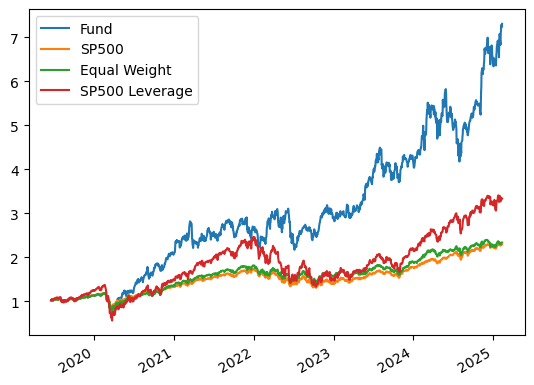

In [22]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['SP500']=sp500
performance['Equal Weight']=equal_weight.sum(axis=1)
performance['SP500 Leverage']=sp500_leverage

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [23]:
years=sorted(list(set(performance.index.year)))

In [24]:
month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

In [25]:
(1+performance_pct.loc[str(2025)]).cumprod()

,Fund,SP500,Equal Weight,SP500 Leverage
2025-01-02,0.986980,0.997543,0.998157,0.989125
2025-01-03,1.016574,1.010016,1.013955,0.996917
2025-01-06,1.010207,1.015834,1.017880,1.028380
2025-01-07,0.992848,1.004351,1.009642,1.006377
2025-01-08,0.998337,1.005818,1.011231,0.989421
2025-01-10,0.999829,0.990462,0.995274,0.960260
2025-01-13,0.990275,0.991998,1.000665,0.952278
2025-01-14,1.009663,0.993363,1.008246,0.965370
2025-01-15,1.027710,1.011432,1.022711,0.994763
2025-01-16,1.036534,1.009487,1.029097,1.006377


In [26]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [27]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,0.125662,0.854261,0.246000,0.084856,0.504798,0.571611,0.130910
SP500,0.128370,0.172353,0.305055,-0.186464,0.267092,0.255893,0.035355
Equal Weight,0.125662,0.204517,0.342978,-0.130908,0.216874,0.184232,0.039192
SP500 Leverage,0.232929,0.194817,0.656196,NaN,0.499447,0.484623,0.050253


In [28]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [29]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,...,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02
Fund,0.023039,0.006979,-0.008732,0.027834,0.029057,0.027443,0.036859,-0.007839,-0.086484,-0.196089,...,0.145463,-0.019727,-0.085913,0.085286,0.071420,0.040990,0.275754,-0.046094,0.099824,0.049677
SP500,0.017469,0.005987,-0.008106,0.025454,0.034409,0.026687,0.037872,-0.009665,-0.085956,-0.161197,...,0.054002,0.034437,0.010030,0.038066,0.042457,0.000035,0.055180,-0.025806,0.029386,0.012614
Equal Weight,0.023039,0.006979,-0.008732,0.027834,0.029057,0.027443,0.036859,-0.007839,-0.086484,-0.196089,...,0.047368,0.012651,0.030334,0.029394,0.045305,-0.013751,0.074215,-0.064602,0.035671,0.011951
SP500 Leverage,0.026310,0.034599,-0.064692,0.053049,0.043229,0.058834,0.069655,-0.004618,-0.203045,-0.291766,...,0.071362,0.086993,0.018843,0.038936,0.054886,0.005852,0.096945,-0.040481,0.067630,0.021214


In [30]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500'].iloc[-2]/performance['SP500'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [31]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.491988
Fund Vol,0.538908
Bench Vol,0.202570
Fund Return,7.171498
Bench Return,2.288887
Sharpe Ratio,2.505039


In [32]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500 Leverage']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500 Leverage'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500 Leverage'].iloc[-2]/performance['SP500 Leverage'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [33]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.558919
Fund Vol,0.538908
Bench Vol,0.362438
Fund Return,7.171498
Bench Return,3.336068
Sharpe Ratio,2.505039


In [34]:
shares=pd.DataFrame()
for date in dates_end[:-1]:
    shares[date]=tracking[date][1]
shares=shares.T

In [35]:
positions=pd.DataFrame()
positions.index=dataframe.index
positions=pd.concat([positions,shares],axis=1)
positions=positions.ffill()

In [36]:
#dataframe.iloc[:-1].to_excel('SP500 Prices.xlsx')
#positions[:-1].to_excel('Rebalancing.xlsx')